# Simulating the spread of information on Facebook

### Facebook, a giant social network, is commonly a carrier of news and information from all over the world. Using the Susceptible-Infected-Recovered (SIR) model, we will be simulating the spread of information on Facebook, and we will do so for different random graph models as well, to analyse the deviations in the results and the properties of the graph which may have influenced this result.

We will be considering the graph of infected nodes over time. Using the least squares method of summing the squares of the difference, we will quantify the difference in the graphs plotted using Facebook's simulation, and individual random graph models. Thus from this, we will analyse how different properties may cause the similarity to Facebook in spread of information to differ.

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import time as tm

First, we shall define a function to perform the simulation of the spread of information, and obtain the values of the number of infected nodes over time.

In [3]:
def sir_draw(g, si, ir, ini, time):
    print(f"\nInfection has begun, with initial probability of infection being {ini}.")
    print(f"Chance of susceptible node becoming infected: {si}")
    print(f"Chance of infected node recovering: {ir}")
    
    size = len(g.nodes())
    
    inin = np.random.ranf(size) < ini
    state = inin * 1
    i_plot = [sum(state)]
    r_plot = [0]
    s_plot = [size-i_plot[0]]
    
    def color(n):
        if state[n] == 0:
            return 'b'
        elif state[n] == 1:
            return 'r'
        else:
            return 'g'
    
    def infect():
        base = nx.adjacency_matrix(g)
        infected = state == 1
        infected_p = base * infected
        infected_pdist = np.random.ranf(size) < 1-(1-si)**infected_p
        infected_new = [i if state[i] == 0 and infected_pdist[i] == 1 else -1 for i in range(size)]
        infected_new = np.array(list(filter(lambda x: x >=0, infected_new)))
 
        state_new = state.copy()
        if np.size(infected_new) > 0:
            state_new[infected_new] = 1
        recovery = np.random.ranf(size) < ir
        recovered = [i if recovery[i] == 1 and state[i] == 1 else -1 for i in range(size)]
        recovered = np.array(list(filter(lambda x: x >= 0, recovered)))
        if np.size(recovered) > 0:
            state_new[recovered] = -1
        
        return state_new
    
    for t in range(1, time+1):
        state = infect()
        state_count = Counter(state)
        s_plot.append(state_count[0])
        i_plot.append(state_count[1])
        r_plot.append(state_count[-1])
        if state_count[1] == 0:
            print(f'\nThe infection has been eradicated. Time taken: {t}')
            break
            
    colors = list(map(color, range(size)))
    print(f"\nSIR model of graph after {t} time steps:")
    nx.draw(g, node_color = colors)
    plt.show()
    plt.clf()
    
    plt.plot(range(0, t+1), s_plot, color = 'b', label = 'Susceptible')
    plt.plot(range(0, t+1), i_plot, color = 'r', label = 'Infected')
    plt.plot(range(0, t+1), r_plot, color = 'g', label = 'Recovered')
    plt.legend(loc = 'upper right')
    plt.xlabel('Time')
    plt.ylabel('Number of nodes')
    plt.show()

    return 

In [4]:
def sir_dev(g, si, ir, ini, time):
    size = len(g.nodes())
    
    # Initial infection of nodes with p = 0.01
    inin = np.random.ranf(size) < ini
    state = inin * 1
    
    # i_plot refers to values of infected nodes that will be recorded
    i_plot = [sum(state)/size]
    
    def infect():
        base = nx.adjacency_matrix(g)
        infected = state == 1
        
        # Matrix multiplication to obtain array of number of neighbouring infected nodes
        infected_p = base * infected
        infected_pdist = np.random.ranf(size) < 1-(1-si)**infected_p
        
        # Infected nodes based on whether node is susceptible
        infected_new = [i if state[i] == 0 and infected_pdist[i] == 1 else -1 for i in range(size)]
        infected_new = np.array(list(filter(lambda x: x >=0, infected_new)))
 
        # Updating recovered and infected nodes
        state_new = state.copy()
        if np.size(infected_new) > 0:
            state_new[infected_new] = 1
        recovery = np.random.ranf(size) < ir
        recovered = [i if recovery[i] == 1 and state[i] == 1 else -1 for i in range(size)]
        recovered = np.array(list(filter(lambda x: x >= 0, recovered)))
        if np.size(recovered) > 0:
            state_new[recovered] = -1
        
        return state_new
    
    for t in range(1, time+1):
        state = infect()
        state_count = Counter(state)
        i_plot.append(state_count[1]/size)

    return i_plot

Now with the function defined, we must first create the graph of Facebook, to perform the SIR simulation later on.

In [5]:
gf = nx.Graph()
with open("facebook_combined.txt") as f:
    edges = f.read().split("\n")
    edges.pop()
    edges = [tuple(map(int, edge.split(" "))) for edge in edges]
gf.add_edges_from(edges)

Now, we can define functions to perform tests on the models. We set the initial probability of a node being infected as 0.01, and the total time 50. For now, we will be varying both the probability of an S node becoming I, and an I node becoming R, in steps of 0.1, and each deviation is averaged over 10 trials.

In [6]:
ini = 0.01
time = 50
num = 30

def avg_test(ps):
    si = ps[0]
    ir = ps[1]
    
    def test(irre):
        facebook_dev = np.array(sir_dev(gf, si, ir, ini, time))
        test_dev = np.array(sir_dev(g, si, ir, ini, time))
        dev = sum((facebook_dev - test_dev)**2)
        return dev

    test = np.vectorize(test)
    devs = test(np.full(num, 1))
    print(f"Done with (si, ir) = {(si, ir)}")
    return np.mean(devs)

avg_test = np.vectorize(avg_test)

def experiment(g):
    dt = np.dtype([('ir', np.float64), ('rs', np.float64)])
    ps = np.array([[(ir, rs) for ir in np.arange(0.1, 1, 0.1)] for rs in np.arange(0.1, 1, 0.1)], dtype = dt)
    res = avg_test(ps)
    return res


## Facebook Graph

Before we start comparing graphs however, we will test the SIR model of Facebook with itself, to provide a standard for the amount of deviation we can expect.

In [ ]:
g = gf
res = experiment(g)
print(res)
print(f"Average deviation: {np.mean(res)}")

## Erdos-Renyi Model

We will be simulating the spread of information in the Erdos-Renyi Model, and observing the differences in the graph that are calculated. The Erdos-Renyi graph is not known for being a particularly accurate model of a social network, but it is a good starting point for our analysis.

In [ ]:
n = 4039
p = 88234 / (n * (n-1) / 2)

g = nx.erdos_renyi_graph(n, p)
res = experiment(g)
print(res)
print(f"Average deviation: {np.mean(res)}")

## Watts-Strogatz Model

The Watts-Strogatz model is known for having a high clustering coefficient, but not being able to produce a scale free degree distribution. By modelling the SIR model in this graph, we will investigate how clustering coefficient may affect the spread of information.

In [ ]:
n = 4039
k = 44
beta = 1 - (0.6055 * (4 * (k-1)) / (3 * (k-2))) ** (1/3)

g = nx.watts_strogatz_graph(n, k, beta)
res = experiment(g)
print(res)
print(f"Average deviation: {np.mean(res)}")

## Barabasi-Albert Model

The Barabasi-Albert model is unlike the Watts-Strogatz model, in that it cannot produce a graph with a high clustering coefficient, but it will give a scale free degree distribution distinctively following a power law. From modelling using this graph, we hope to have some insights on how degree distribution may affect the spread of information.

In [ ]:
n = 4039
m = 22

g = nx.barabasi_albert_graph(4039, 22)
res = experiment(g)
print(res)
print(f"Average deviation: {np.mean(res)}")

## Klemm-Eguiluz Model

The Klemm-Eguiluz model is a hybrid. A crossover model of a high clustering graph and the Barabasi-Albert graph, it is able to produce both high clustering coefficients and scale free degree distribution by varying the extent of crossover, represented by $\mu$. This graph would combine our previous analysis.

To use this graph however, we would first have to define it (as this graph is not in the library).

In [ ]:
def klemm_eguiluz(n, m, mu):
    # initial condition of complete graphs with m nodes
    g = nx.complete_graph(m)
    # list used to represent whether or not a node is activated(1) or deactivated(0)
    activation = list(np.ones(m))
    
    for i in range(m, n):
        # generate list of edges which are to be randomly rewired
        mu_factor = np.random.ranf(m) < mu
        activated = [x for x in range(i) if activation[x] == 1]
        targets = set([activated[j] for j in range(m) if mu_factor[j] == 0])
        
        # Linear preferential attachment
        p_total = sum(map(g.degree, range(i)))
        p_dstr = [g.degree(node) / p_total for node in range(i)]
        
        while len(targets) < m:
            targets.add(np.random.choice(list(range(i)), p = p_dstr))
        g.add_edges_from(zip(np.full(m, i), list(targets)))
        
        # Activation and deactivation where p = a / k, and 1/a = sum of 1/k
        
        k = [g.degree(active)**-1 for active in activated]
        a = sum(k)
        p_deact = [l / a for l in k]
        deactivated = np.random.choice(activated, p = p_deact)
        activation[deactivated] = 0
        activation.append(1)
                
    return g

In [ ]:
n = 4039
m = 22
mu = 0.09

g = klemm_eguiluz(n, m, mu)
res = experiment(g)
print(res)
print(f"Average deviation: {np.mean(res)}")

## Chang-Chang Model

A model recently devised by NTU interns Kevin Chang and Chang Hexiang, this model aims to combine stochastic block models with geometric models. This model is capable of giving high clustering coefficients, though often with low transitivity, and scale free degree distribution, while creating noticeable clusters of nodes.

In [ ]:
def chang_chang(n, k, phi, chi, delta):
    
    g = nx.Graph()
    
    def post_gen(irrelevant):
        theta, norm = np.random.ranf() * np.pi * 2, np.random.ranf()
        x, y = np.cos(theta) * norm, np.sin(theta) * norm
        return [x, y]
    
    clusters = [[int(i)] for i in range(chi)]
    cluster_b = [tuple(post_gen(1)) for i in clusters]
    posts = cluster_b.copy()
    
    def cluster_b_gen(node):
        return (node, dict(pos = cluster_b[node]))
    
    initial = list(map(cluster_b_gen, range(chi)))
    g.add_nodes_from(initial)
    
    def edge_initialize(node):
        target = np.random.choice(range(chi))
        return (node, target)
    
    edges_initialize = list(map(edge_initialize, range(chi)))
    g.add_edges_from(edges_initialize)
    
    for node in range(chi, n):
        pplns = list(map(len, clusters))
        ppln = list(np.array(pplns) / sum(pplns))
        cluster_add = np.random.choice(range(chi), p = ppln)
        i = cluster_add
        clusters[i].append(node)
        
        def delt_gen(node):
            delt = post_gen(1)
            delt = tuple([delt[0] / delta, delt[1] / delta])
            post = (cluster_b[i][0] + delt[0], cluster_b[i][1] + delt[1])
            posts.append(post)
            return post
        
        g.add_node(node, pos = delt_gen(node))

        def edges(k):
            
            def distance(target):
                dist = ((posts[node][0] - posts[target][0]) ** 2 + (posts[node][1] - posts[target][1]) ** 2)**0.5
                return dist
            
            def pcalc(target):
                d = distance(target)
                return ((g.degree(target)+1)**phi) / d
            
            def p_dist(targets):
                dist = np.array(list(map(pcalc, targets)))
                dist = dist / sum(dist)
                return list(dist)
            
            size_n = np.random.randint(1, k)
                
            available = list(range(0, node))
            targets = np.random.choice(available, p = p_dist(available), size = size_n, replace = False)
            edges_add = list(zip(targets, np.full(len(targets), node)))
        
            return edges_add
    
        g.add_edges_from(edges(k))

    return g

In [ ]:
g = chang_chang(4039, 44, 2, 400, 20)
res = experiment(g)
print(res)
print(f"Average deviation: {np.mean(res)}")

## Analysing Results

With the raw data of deviation in graphs now collated, we will attempt to present the data meaningfully to draw useful conclusions from it. We will first record the data in arrays, and then graph them out for each interval of $p_1$ and $p_2$.

In [7]:
def si_dev(data):
    colors = ['r', '#FFA000', 'y', '#B0FF00', 'g', 'c', 'b', 'm', '#FF00FF']
    labels = np.arange(0.1, 1, 0.1)
    
    def si_plot(index):
        xs = np.arange(0.1, 1, 0.1)
        ys = list(data)[index]
        color = colors[index]
        plt.plot(xs, ys, color = color, label = round(labels[index], 1))
        return
    
    res = list(map(si_plot, range(9)))
    plt.title("Different graphs of p2 varying with p1")
    plt.xlabel('Probability of susceptible node becoming infected')
    plt.ylabel('Deviation from Facebook')
    plt.axis([0.1, 1, 0, 0.25])
    plt.legend(loc = 'upper right')
    plt.show()
    return

def ir_dev(data):
    irs = [[data[i, j] for i in range(9)] for j in range(9)]
    colors = ['r', '#FFA000', 'y', '#B0FF00', 'g', 'c', 'b', 'm', '#FF00FF']
    labels = np.arange(0.1, 1, 0.1)
    
    def ir_plot(index):
        xs = np.arange(0.1, 1, 0.1)
        ys = irs[index]
        color = colors[index]
        plt.plot(xs, ys, color = color, label = round(labels[index], 1))
        return
    
    res = list(map(ir_plot, range(9)))
    plt.title("Different graphs of p1 varying with p2")
    plt.xlabel('Probability of infected node recovering')
    plt.ylabel('Deviation from Facebook')
    plt.axis([0.1, 1, 0, 0.25])
    plt.legend(loc = 'upper right')
    plt.show()
    return

## Facebook

We will first be analysing the results collected by testing Facebook against itself. 

In [8]:
ps = np.array([
    ['ir1, rs1', 'ir2, rs1', 'ir3, rs1', '...'],
    ['ir1, rs2', 'ir2, rs2', 'ir3, rs2', '...'],
    ['ir1, rs3', 'ir2, rs3', 'ir3, rs3', '...'],
    ['...']
])

data = np.array([[0.02080302, 0.01494418, 0.00831858, 0.00756293, 0.01235807, 0.00955004,
  0.00824644, 0.00885113, 0.00942325,],
 [0.01993834, 0.00931545, 0.00808403, 0.01054293, 0.0086644 , 0.00733023,
  0.00733579, 0.00836532, 0.00957495,],
 [0.00912985, 0.00984633, 0.00878035, 0.00990589, 0.00985753, 0.00741226,
  0.00749266, 0.00789867, 0.00880596,],
 [0.00870585, 0.01219904, 0.00767792, 0.01079405, 0.00892436, 0.00576853,
  0.00570325, 0.00828198, 0.00966786,],
 [0.0086028 , 0.01028645, 0.00716648, 0.00751979, 0.00767946, 0.00817903,
  0.00735823, 0.00973358, 0.0073669 ],
 [0.00614766, 0.00692177, 0.00878363, 0.00708637, 0.00885416, 0.0125613,
  0.00696321, 0.01201769, 0.00633257],
 [0.00624534, 0.00862905, 0.00477428 ,0.00697441, 0.0105418 , 0.00720436,
  0.00862272, 0.00885568, 0.01222866],
 [0.00596445, 0.00645002, 0.00904297 ,0.00822784, 0.00360733, 0.00509429,
  0.01284066, 0.01327511, 0.01145073],
 [0.00552436, 0.00832746, 0.00535858, 0.00564062, 0.0089312 , 0.00647061,
  0.00623707, 0.00987385, 0.00951504]])

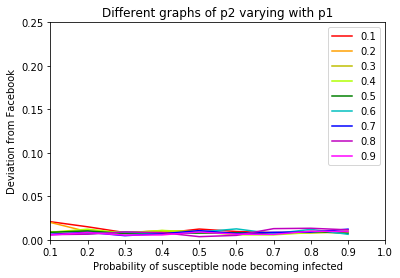

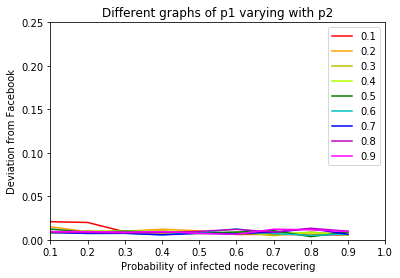

Overall deviation: 0.0088


In [9]:
si_dev(data)
ir_dev(data)
print(f"Overall deviation: {round(np.mean(data), 4)}")

## Erdos-Renyi


In [10]:
ps = np.array([
    ['ir1, rs1', 'ir2, rs1', 'ir3, rs1', '...'],
    ['ir1, rs2', 'ir2, rs2', 'ir3, rs2', '...'],
    ['ir1, rs3', 'ir2, rs3', 'ir3, rs3', '...'],
    ['...']
])

data = np.array([[0.14225537, 0.06724058, 0.08525547, 0.06717863, 0.05183285, 0.03664901,
  0.02506059, 0.01396215, 0.01544854,],
 [0.12150569, 0.06492175, 0.07063671, 0.06095119, 0.05329, 0.04115602,
  0.01920169, 0.01585987, 0.01284531,],
 [0.10554806, 0.06743757, 0.05852671, 0.06597825, 0.06461865, 0.03732605,
  0.02760354, 0.01545565, 0.01115252,],
 [0.09553023, 0.06694235, 0.06388507, 0.06868653, 0.05172258, 0.0333171,
  0.02535766, 0.01781016, 0.01350848,],
 [0.09231235, 0.05190298, 0.07019163, 0.07272339, 0.05718491, 0.03470197,
  0.01881175, 0.01548278, 0.00937618,],
 [0.08105561, 0.06262277, 0.06193306, 0.06065694, 0.06162209, 0.03581969,
  0.02259339, 0.01356435, 0.01115709,],
 [0.07803117, 0.05971541, 0.06002975, 0.07234261, 0.05292841, 0.04137785,
  0.02586505, 0.01561705, 0.01413444,],
 [0.07417834 ,0.05426982, 0.05037387 ,0.07665006, 0.06093141, 0.03786604,
  0.02154202 ,0.01611165, 0.01080038,],
 [0.07054952 ,0.05130133, 0.04254662 ,0.08201968, 0.05906688, 0.0405721,
  0.02440787 ,0.01286374, 0.01104051]])

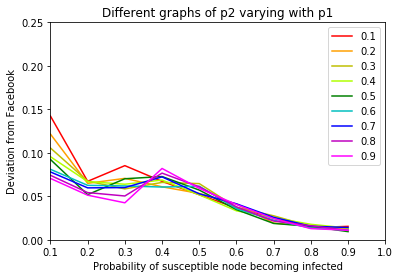

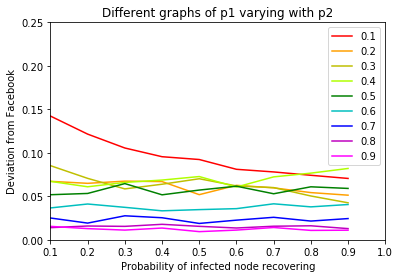

Overall deviation: 0.0482


In [11]:
si_dev(data)
ir_dev(data)
print(f"Overall deviation: {round(np.mean(data), 4)}")

## Watts-Strogatz

In [12]:
ps = np.array([
    ['ir1, rs1', 'ir2, rs1', 'ir3, rs1', '...'],
    ['ir1, rs2', 'ir2, rs2', 'ir3, rs2', '...'],
    ['ir1, rs3', 'ir2, rs3', 'ir3, rs3', '...'],
    ['...']
])

data = np.array([[0.07290162, 0.03277539 ,0.01994182, 0.01625394 ,0.01470377, 0.01157467,
  0.00991658, 0.0113041 , 0.01181131],
 [0.07147918, 0.02909683 ,0.01725335 ,0.01275466, 0.01394646 ,0.01511897,
  0.01004901, 0.00773531 ,0.01634952],
 [0.06330913, 0.02653418 ,0.01895634 ,0.01499369, 0.01154617 ,0.0101934,
  0.01526823, 0.01229668, 0.01151028],
 [0.06999906, 0.02931757, 0.02303823 ,0.01923954, 0.0175848 , 0.01443407,
  0.01154949, 0.01119819 ,0.01035103],
 [0.05984491, 0.03009009 ,0.01827927 ,0.01539811, 0.01910175, 0.01702252,
  0.01051639, 0.01431296, 0.01065453],
 [0.06142218, 0.02542798, 0.02625435 ,0.01206659, 0.0150041 , 0.00997111,
  0.01177218, 0.0132993 , 0.01305137],
 [0.05936253, 0.0259481 , 0.02181117 ,0.02357988, 0.01404298, 0.01358386,
  0.01468038, 0.01354256, 0.0175532 ],
 [0.05530387, 0.02411213, 0.022487   ,0.02153023, 0.01758315, 0.01151969,
  0.01634381, 0.01171928, 0.02231813],
 [0.04621269, 0.02926934, 0.02524491 ,0.01895068, 0.02236834, 0.01300163,
  0.01645486, 0.01608677, 0.01488095]])

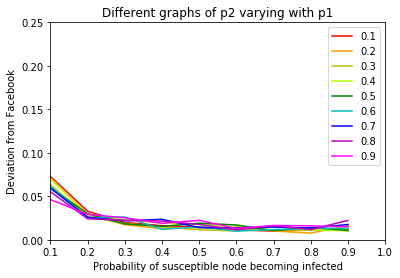

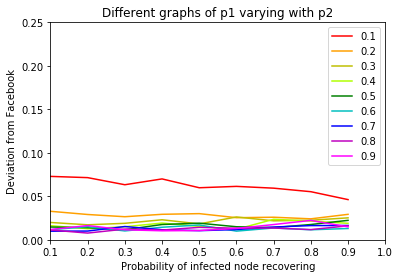

Overall deviation: 0.022


In [13]:
si_dev(data)
ir_dev(data)
print(f"Overall deviation: {round(np.mean(data), 4)}")

## Barabasi-Albert

In [14]:
ps = np.array([
    ['ir1, rs1', 'ir2, rs1', 'ir3, rs1', '...'],
    ['ir1, rs2', 'ir2, rs2', 'ir3, rs2', '...'],
    ['ir1, rs3', 'ir2, rs3', 'ir3, rs3', '...'],
    ['...']
])

data = np.array([[0.1599718,  0.09950235, 0.09562914, 0.08182253, 0.05271395, 0.03231408,
  0.02333289, 0.01426828, 0.01237452],
 [0.14448429, 0.09520115, 0.08536478 ,0.07031608, 0.05415074, 0.03390942,
  0.02171496, 0.01506137, 0.00876762],
 [0.12126135, 0.08466091 ,0.07967544 ,0.07297227, 0.06233569, 0.03446753,
  0.02245137, 0.01519733 ,0.00844743],
 [0.10717302, 0.07607857, 0.08180823 ,0.08199871 ,0.05002935, 0.03565148,
  0.02076592, 0.01310991, 0.01616288],
 [0.09402698, 0.06123815, 0.09978907 ,0.07271114, 0.05663851, 0.03687092,
  0.02179701, 0.01780875, 0.00915437],
 [0.0912267 , 0.07134596, 0.07863331 ,0.0809196 , 0.06016872, 0.04027771,
  0.02050069, 0.01856924, 0.01123287],
 [0.07926328, 0.06819882, 0.08855666 ,0.08326515, 0.06600915, 0.03802988,
  0.02510671, 0.01640178, 0.01213519],
 [0.07452162, 0.06506162, 0.08370956 ,0.09083014, 0.06576755, 0.04185837,
  0.028338  , 0.01589874, 0.01426858],
 [0.07061495, 0.05493873, 0.0878581  ,0.10374717, 0.06719138, 0.04542618,
  0.02765327, 0.02256782, 0.01561672]])

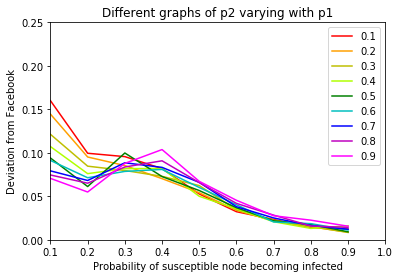

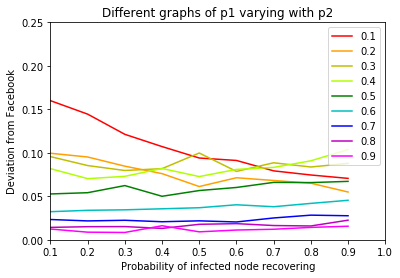

Overall deviation: 0.0553


In [15]:
si_dev(data)
ir_dev(data)
print(f"Overall deviation: {round(np.mean(data), 4)}")

## Klemm-Eguiluz

In [16]:
ps = np.array([
    ['ir1, rs1', 'ir2, rs1', 'ir3, rs1', '...'],
    ['ir1, rs2', 'ir2, rs2', 'ir3, rs2', '...'],
    ['ir1, rs3', 'ir2, rs3', 'ir3, rs3', '...'],
    ['...']
])

data = np.array([[0.1441318,  0.07726905, 0.06480439, 0.06659802, 0.04369604, 0.03771371,
  0.03129736, 0.01984363, 0.01254561],
 [0.1225531 , 0.07607843, 0.06569143, 0.06033175, 0.04666165, 0.03195593,
  0.01795198, 0.01749307, 0.01190848],
 [0.09646824, 0.06653007, 0.07516584 ,0.05070637, 0.03871701, 0.03270394,
  0.02376575, 0.01834583, 0.01410374],
 [0.08984997, 0.06130565, 0.06586599 ,0.05251613, 0.04945462, 0.02980513,
  0.0179108 , 0.01717343, 0.01363278],
 [0.08239394, 0.06195835, 0.06608318 ,0.05312776, 0.04464339, 0.03067563,
  0.02146054, 0.01284421, 0.01512595],
 [0.07226858, 0.05270538, 0.05698781 ,0.0592745 , 0.04744896, 0.02983147,
  0.01980806, 0.01437304, 0.01230096],
 [0.05910329, 0.0566723 , 0.05893846 ,0.05335684, 0.04964196, 0.03435478,
  0.02199088, 0.01626125, 0.01096008],
 [0.05420792, 0.05364147, 0.05823347 ,0.05775127, 0.05245431, 0.03709256,
  0.02399461, 0.0169875 , 0.01146841],
 [0.05285525, 0.05639357, 0.0591763  ,0.06963089, 0.05234426, 0.03431121,
  0.02421655, 0.01240666, 0.01678644]])

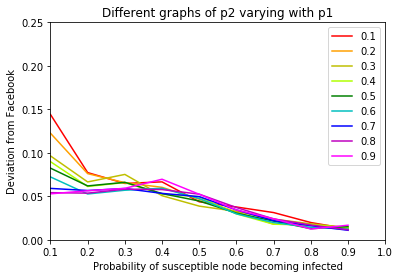

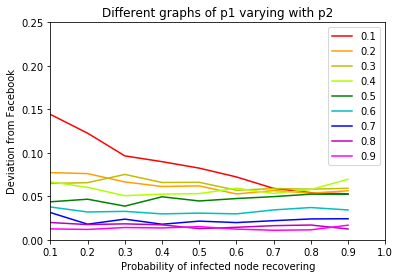

Overall deviation: 0.0447


In [17]:
si_dev(data)
ir_dev(data)
print(f"Overall deviation: {round(np.mean(data), 4)}")

## Chang-Chang

In [18]:
ps = np.array([
    ['ir1, rs1', 'ir2, rs1', 'ir3, rs1', '...'],
    ['ir1, rs2', 'ir2, rs2', 'ir3, rs2', '...'],
    ['ir1, rs3', 'ir2, rs3', 'ir3, rs3', '...'],
    ['...']
])

data = np.array([[0.26935249, 0.13498912 ,0.09764618 ,0.06054564, 0.04936707 ,0.03765323,
  0.03815052, 0.0385813, 0.03759779],
 [0.23688125, 0.16281661 ,0.09022565, 0.06073395 ,0.04654442, 0.04495526,
  0.05316291, 0.04179426 ,0.04640305],
 [0.24559265, 0.16347665, 0.10232284 ,0.06796528 ,0.05528803, 0.03871423,
  0.03862125, 0.05178403, 0.06182995],
 [0.20010079, 0.15521104, 0.10755296 ,0.06725136 ,0.06131908, 0.05050081,
  0.04037165, 0.0516321 , 0.04318283],
 [0.18705227, 0.15406411, 0.10753053 ,0.07286988 ,0.06420735, 0.05492103,
  0.06019517, 0.05741596, 0.07930874],
 [0.18322458, 0.1718704 , 0.1102269  ,0.08391252 ,0.06893202, 0.05976991,
  0.05408405, 0.05025788, 0.07826184],
 [0.18565461, 0.16865647, 0.12459907 ,0.09062803 ,0.0672359 , 0.05826575,
  0.05779632, 0.06479238, 0.06427861],
 [0.19297127 ,0.18903868, 0.12808618 ,0.08474002 ,0.08392554, 0.06755908,
  0.05985261 ,0.07308133, 0.078167  ],
 [0.19468455 ,0.1941481 , 0.15994423 ,0.10983121, 0.08026858, 0.08203675,
  0.0574545  ,0.07452427, 0.09778332]])

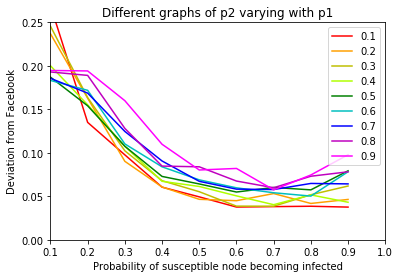

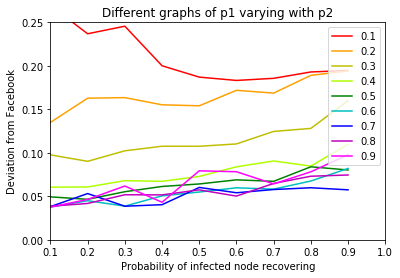

Overall deviation: 0.0955


In [19]:
si_dev(data)
ir_dev(data)
print(f"Overall deviation: {round(np.mean(data), 4)}")